In [ ]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import inspeqtor as sq
from inspeqtor.experimental.ctyping import ParametersDictType
from inspeqtor.v2.optimize import init_opt_state, sample, update_gp, gaussian_process

sq.experimental.utils.enable_jax_x64()

In [2]:
def true_fn(x):
    return jnp.sin(4 * x) + jnp.cos(2 * x)


def noisy_fn(key, x, noise=0.3):
    y = true_fn(x)

    return y + jax.random.normal(key, shape=y.shape) * noise

class XControl(sq.experimental.control.BaseControl):
    total_dt = 10

    def get_bounds(self) -> tuple[ParametersDictType, ParametersDictType]:
        return {"x": -3.0}, {"x": 3.0}

    def get_envelope(self, params: ParametersDictType):
        def envelope(t):
            return jnp.zeros_like(jnp.arange(self.total_dt))

        return envelope

In [3]:
total_dt = 10 # Does not matter in the example
ctrl_seq = sq.control.ControlSequence(
    controls={"x": XControl(total_dt)}, total_dt=total_dt
)

n = 10
key = jax.random.key(0)
key, x_key, y_key = jax.random.split(key, 3)
ravel_fn, _ = sq.control.ravel_unravel_fn(ctrl_seq)
x = jax.vmap(ravel_fn)(jax.vmap(ctrl_seq.sample_params)(jax.random.split(x_key, n)))
y = noisy_fn(y_key, x)

In [4]:
opt_state = init_opt_state(x, y, ctrl_seq)

key = jax.random.key(0)
for step in range(10):
    key, sample_key, exp_key = jax.random.split(key, 3)

    x_candidate = sample(sample_key, opt_state, num_suggest=5, exploration_factor=2.)
    # Evaluate at new candidate
    y_new = noisy_fn(exp_key, x_candidate)
    # Update the GP
    opt_state = update_gp(opt_state, x=x_candidate, y=y_new)

Optimization terminated successfully.
         Current function value: 0.951876
         Iterations: 14
         Function evaluations: 36
         Gradient evaluations: 36
Optimization terminated successfully.
         Current function value: 6.887604
         Iterations: 10
         Function evaluations: 24
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 7.769033
         Iterations: 11
         Function evaluations: 22
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 5.233201
         Iterations: 11
         Function evaluations: 25
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 12.274840
         Iterations: 11
         Function evaluations: 20
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: 11.648742
         Iterations: 12
         Function evaluations: 21


/Users/porametpathumsoot/University/PhD/Projects/espresso/inspeqtor/.venv/lib/python3.13/site-packages/scipy/optimize/_minimize.py:733: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


         Current function value: 21.685869
         Iterations: 3
         Function evaluations: 88
         Gradient evaluations: 79


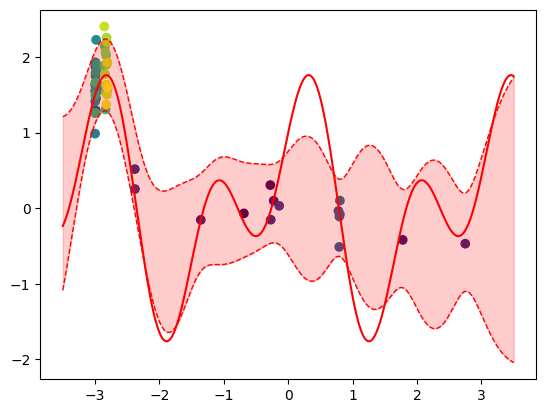

In [5]:
exp_x = opt_state.dataset.X
exp_y = opt_state.dataset.y

assert isinstance(exp_x, jnp.ndarray) and isinstance(exp_y, jnp.ndarray)

fig, ax = plt.subplots()
ax.scatter(exp_x, exp_y, label="Observations", c=jnp.arange(opt_state.dataset.n))

x_test = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
y_true = true_fn(x_test)
ax.plot(x_test, y_true, label="Latent function", color="red")

mean, variance = gaussian_process(x_test, opt_state.dataset)
ax.fill_between(
    x_test.squeeze(),
    mean - 2 * variance,
    mean + 2 * variance,
    alpha=0.2,
    label="Two sigma",
    color="red",
)
ax.plot(
    x_test,
    mean - 2 * variance,
    linestyle="--",
    linewidth=1,
    color="red",
)
ax.plot(
    x_test,
    mean + 2 * variance,
    linestyle="--",
    linewidth=1,
    color="red",
)